In [17]:
import collections
import re


In [18]:

import re
import requests

def download_time_machine():
    """独立下载并处理时间机器数据集"""
    url = "https://www.gutenberg.org/files/35/35-0.txt"
    response = requests.get(url)
    lines = response.text.split('\n')
    #print(lines[0])  # 输出首行
    #print(lines[-100]) # 输出第11行
    # 跳过古登堡计划的元数据部分

    
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() 
           for line in lines if line.strip()]

lines = download_time_machine()
print(f'文本总行数: {len(lines)}')
print(lines[0])  # 输出首行
print(lines[10]) # 输出第11行


文本总行数: 2780
start of the project gutenberg ebook
vi the sunset of mankind


In [19]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['start', 'of', 'the', 'project', 'gutenberg', 'ebook']
['the', 'time', 'machine']
['an', 'invention']
['by', 'h', 'g', 'wells']
['contents']
['i', 'introduction']
['ii', 'the', 'machine']
['iii', 'the', 'time', 'traveller', 'returns']
['iv', 'time', 'travelling']
['v', 'in', 'the', 'golden', 'age']
['vi', 'the', 'sunset', 'of', 'mankind']


In [20]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [21]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [22]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])#用的_get_item_

文本: ['start', 'of', 'the', 'project', 'gutenberg', 'ebook']
索引: [832, 4, 1, 1431, 1432, 1433]
文本: ['vi', 'the', 'sunset', 'of', 'mankind']
索引: [1441, 1, 401, 4, 589]


In [28]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = download_time_machine()
    tokens = tokenize(lines, 'word')
    vocab = Vocab(tokens,0)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(32907, 4601)

In [29]:
import random
import torch


tokens = tokenize(download_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2287),
 ('i', 1268),
 ('and', 1245),
 ('of', 1165),
 ('a', 819),
 ('to', 684),
 ('was', 552),
 ('in', 545),
 ('that', 443),
 ('my', 441)]

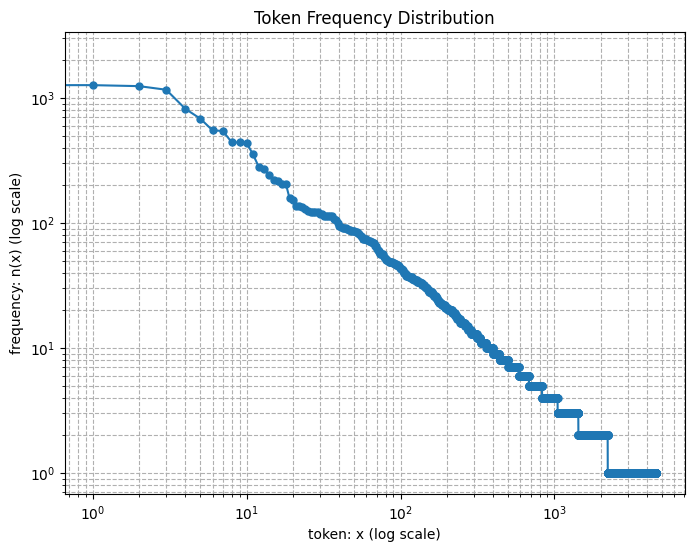

In [36]:

import matplotlib.pyplot as plt

# 假设vocab是已定义的词汇表对象
freqs = [freq for token, freq in vocab.token_freqs]

plt.figure(figsize=(8, 6))
plt.plot(freqs, marker='o', linestyle='-', markersize=5)
plt.xlabel('token: x (log scale)')
plt.ylabel('frequency: n(x) (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.title('Token Frequency Distribution')
plt.show()


In [38]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]#二元语法词频统计

[(('of', 'the'), 311),
 (('in', 'the'), 173),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 106),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [39]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 63),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('the', 'white', 'sphinx'), 12)]

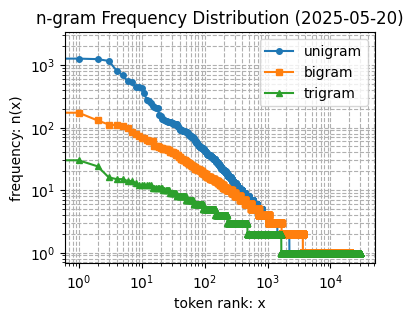

In [41]:
# 准备频率数据
unigram_freqs = [freq for token, freq in vocab.token_freqs]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

# 创建画布
plt.figure(figsize=(4, 3))

# 绘制三条曲线
plt.plot(unigram_freqs, label='unigram', marker='o', markersize=4)
plt.plot(bigram_freqs, label='bigram', marker='s', markersize=4) 
plt.plot(trigram_freqs, label='trigram', marker='^', markersize=4)

# 设置坐标轴
plt.xscale('log')
plt.yscale('log')
plt.xlabel('token rank: x')
plt.ylabel('frequency: n(x)')
plt.grid(True, which="both", linestyle='--')

# 添加图例和标题
plt.legend()
plt.title('n-gram Frequency Distribution (2025-05-20)')
plt.show()


In [43]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [45]:
my_seq = list(range(35))
print(my_seq)
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
X:  tensor([[ 7,  8,  9, 10, 11],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [18, 19, 20, 21, 22]])
X:  tensor([[27, 28, 29, 30, 31],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [13, 14, 15, 16, 17]])
X:  tensor([[22, 23, 24, 25, 26],
        [ 2,  3,  4,  5,  6]]) 
Y: tensor([[23, 24, 25, 26, 27],
        [ 3,  4,  5,  6,  7]])


In [50]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [51]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X:  tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


In [ ]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [ ]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab